# Data Analytics Project - Models

# Pair 2 - ESCORTS LSTM

---

# 1. Import required modules

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


---

# 2. Get Pair 2 Orders Dataset

## 2.1. Get the orders

In [2]:
orders_df = pd.read_csv('../../Preprocess/Pair2/Pair2_orders.csv')
orders_df.head()

,Date,BEML_Close,ESCORTS_Close,Spread,zscore,Orders
0,2018-08-06,909.099976,880.049988,29.049988,1.821236,SHORT
1,2018-08-07,868.599976,873.700012,-5.100037,0.672698,FLAT
2,2018-08-08,825.150024,876.500000,-51.349976,-0.882785,GET_OUT_OF_POSITION
3,2018-08-09,810.150024,878.750000,-68.599976,-1.462939,FLAT
4,2018-08-10,807.750000,865.250000,-57.500000,-1.089624,FLAT


In [3]:
orders_df.tail()

,Date,BEML_Close,ESCORTS_Close,Spread,zscore,Orders
54,2018-10-29,561.150024,591.450012,-30.299988,-0.174830,FLAT
55,2018-10-30,585.650024,603.950012,-18.299988,0.228756,FLAT
56,2018-10-31,587.250000,627.000000,-39.750000,-0.492654,FLAT
57,2018-11-01,632.400024,674.450012,-42.049988,-0.570007,FLAT
58,2018-11-02,688.900024,676.000000,12.900024,1.278078,FLAT


## 2.2. Visualize the orders

Text(0, 0.5, 'zscore')

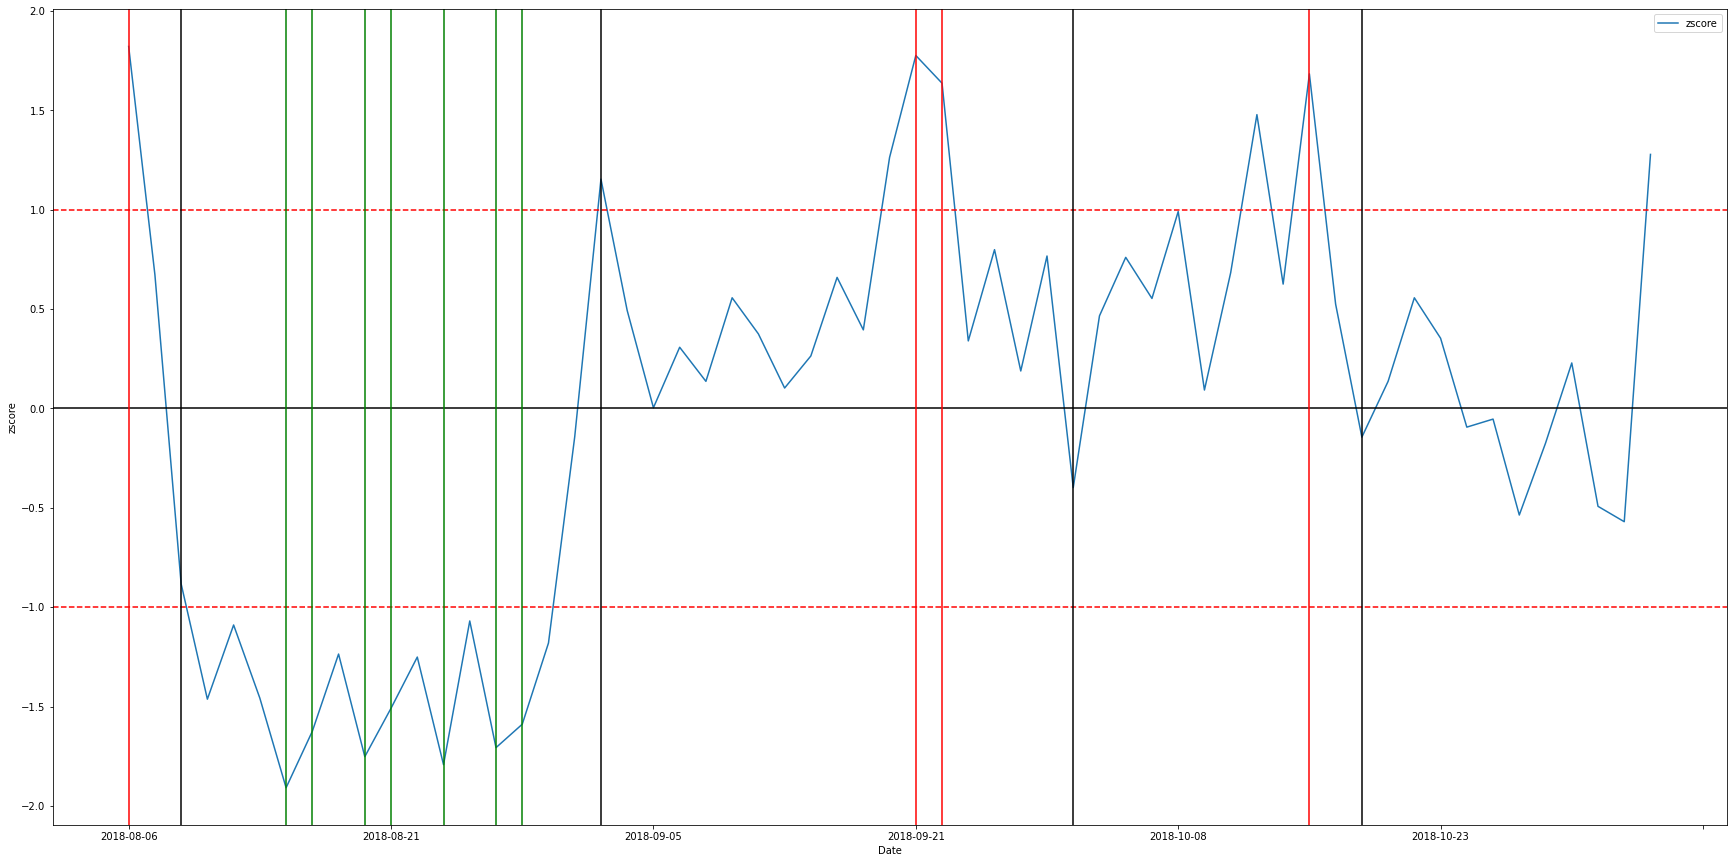

In [4]:
# Plotting the zscore of the Spread
orders_plt = orders_df.plot(x='Date', y='zscore', figsize=(30,15))

# Plotting the lines at mean, 1 and 2 std. dev.
orders_plt.axhline(0, c='black')
orders_plt.axhline(1, c='red', ls = "--")
orders_plt.axhline(-1, c='red', ls = "--")

# Extracting orders
Orders = orders_df['Orders']

# Plot vertical lines where orders are placed
for order in range(len(Orders)):
    
    if Orders[order] != "FLAT":
        
        # GREEN line for a long position
        if Orders[order] == "LONG":
            orders_plt.axvline(x=order, c = "green")
        
        # RED line for a short position
        elif Orders[order] == "SHORT":
            orders_plt.axvline(x=order, c = "red")
        
        # BLACK line for getting out of all positions at that point
        else:
            orders_plt.axvline(x=order, c = "black")

orders_plt.set_ylabel("zscore")

__In the figure above:__
- __Blue line__ - zscore of the Spread
- __Black horizontal line__ at 0 - Mean
- __Red dotted horizontal lines__ - at +1 and -1 standard deviations
- __Green vertical line__ - represents long position taken on that day
- __Red vertical line__ - represents short position taken on that day
- __Black vertical line__ - represents getting out of all open positions till that point


## 2.3 Visualize the close prices of both stocks

Text(0, 0.5, 'Price')

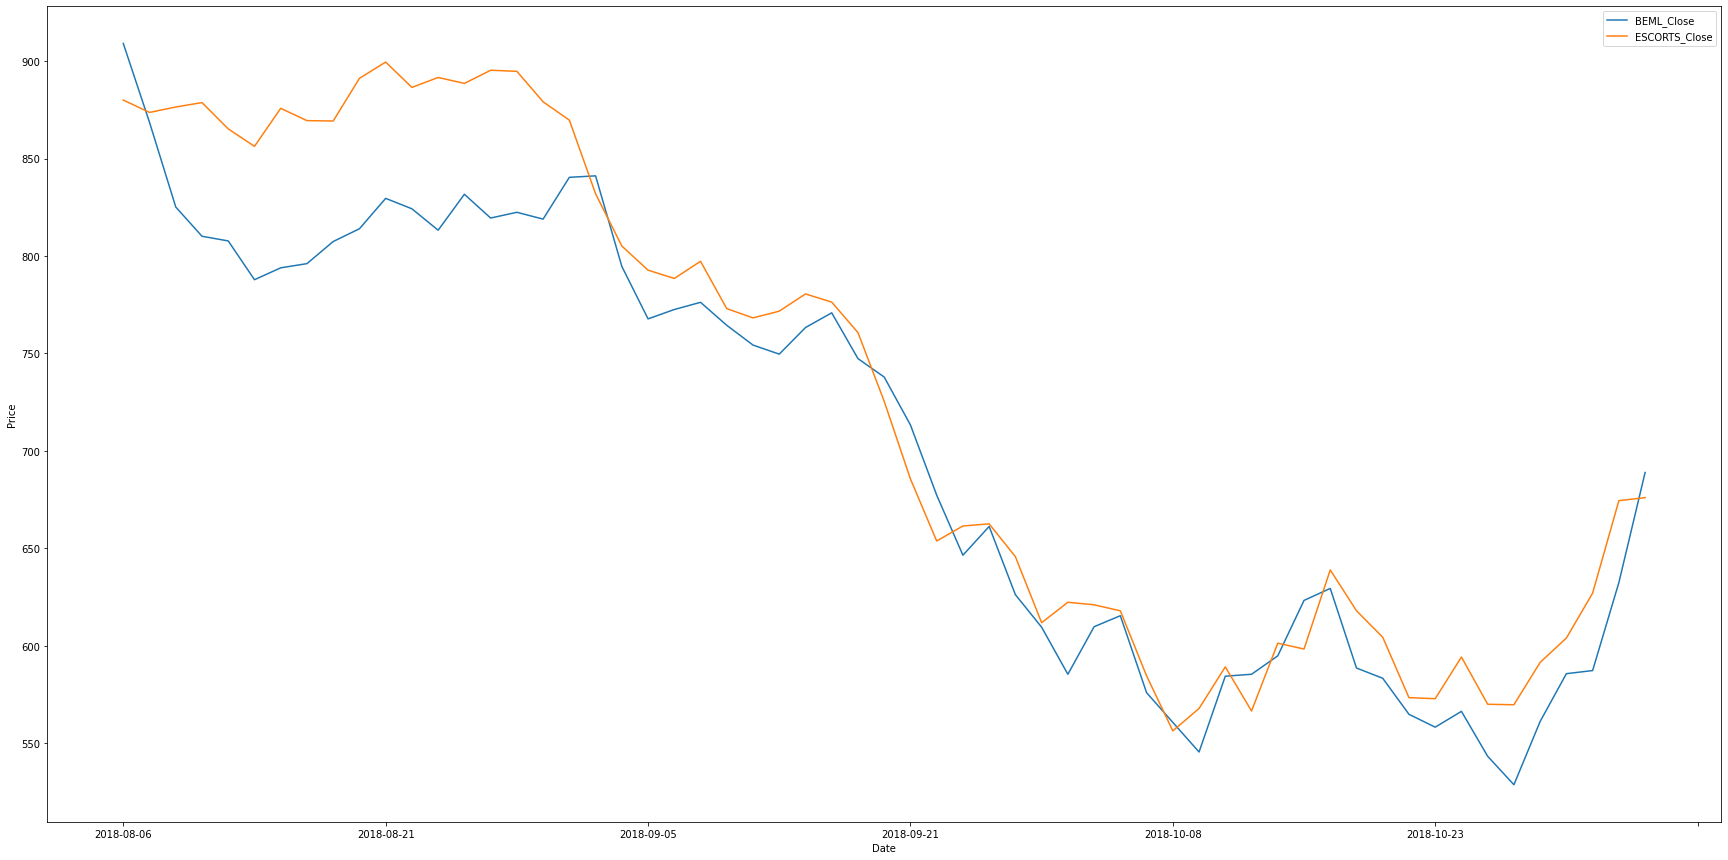

In [5]:
orders_df_plt = orders_df.plot(x='Date', y=['BEML_Close', 'ESCORTS_Close'], figsize=(30,15))
orders_df_plt.set_xlabel("Date")
orders_df_plt.set_ylabel("Price")

---

# 3. ESCORTS Linear Regression Model

## 3.1. Get the Complete ESCORTS dataset

In [6]:
escorts_df = pd.read_csv("../../Storage/Companies_with_names_exchange/ESCORTSNSE.csv")
escorts_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Company,Exchange
0,2017-01-02,324.000000,293.500000,298.950012,320.750000,2996742.0,317.104218,ESCORTS,NSE
1,2017-01-03,329.250000,318.750000,321.500000,326.649994,1859220.0,322.937164,ESCORTS,NSE
2,2017-01-04,329.600006,320.049988,326.700012,321.299988,696439.0,317.647980,ESCORTS,NSE
3,2017-01-05,333.000000,322.700012,322.700012,329.549988,1123767.0,325.804199,ESCORTS,NSE
4,2017-01-06,335.000000,320.000000,331.149994,328.250000,862494.0,324.518982,ESCORTS,NSE


- We can see that we have data from 2017-01-02

## 3.2. Get ESCORTS training data

### 3.2.1 Get complete escorts dataset

In [7]:
escorts_df = escorts_df.drop(columns=['High', 'Low', 'Open', 'Volume', 'Adj Close', 'Company', 'Exchange'])
escorts_df.head()

,Date,Close
0,2017-01-02,320.750000
1,2017-01-03,326.649994
2,2017-01-04,321.299988
3,2017-01-05,329.549988
4,2017-01-06,328.250000


- We can see that the period where the stocks are correlated and co-integration starts from 2018-09-04.
- Thus the test data for which we need to make predictions is from 2018-09-04 to when the period ends at 2018-12-03.
- We take 1 year's worth of training data for our model, which means that the time period of our training data is from 2017-09-03 to 2018-09-04.


### 3.2.2. Crop dataset within training range

In [8]:
escorts_df_train = escorts_df[escorts_df['Date'] >= '2017-09-03']
escorts_df_train.head()

,Date,Close
166,2017-09-04,645.750000
167,2017-09-05,650.299988
168,2017-09-06,651.250000
169,2017-09-07,657.750000
170,2017-09-08,652.950012


In [9]:
escorts_df_train = escorts_df_train[escorts_df_train['Date'] <= '2018-09-04']
escorts_df_train.tail()

,Date,Close
412,2018-08-29,894.799988
413,2018-08-30,879.150024
414,2018-08-31,869.750000
415,2018-09-03,831.950012
416,2018-09-04,805.150024


### 3.2.3 Get the training data

In [10]:
escorts_train = escorts_df_train.copy()

In [11]:
escorts_train = escorts_train.reset_index(drop=True)
escorts_train = escorts_train.copy()
escorts_train.head()

,Date,Close
0,2017-09-04,645.750000
1,2017-09-05,650.299988
2,2017-09-06,651.250000
3,2017-09-07,657.750000
4,2017-09-08,652.950012


In [12]:
escorts_train_plot_copy = escorts_train.copy()
escorts_train.tail()

,Date,Close
246,2018-08-29,894.799988
247,2018-08-30,879.150024
248,2018-08-31,869.750000
249,2018-09-03,831.950012
250,2018-09-04,805.150024


In [13]:
escorts_train = escorts_train.drop(columns=['Date'])
escorts_train = escorts_train.values
escorts_train

array([[ 645.75      ],
       [ 650.29998779],
       [ 651.25      ],
       [ 657.75      ],
       [ 652.95001221],
       [ 658.5       ],
       [ 677.25      ],
       [ 667.04998779],
       [ 670.79998779],
       [ 668.54998779],
       [ 667.        ],
       [ 677.45001221],
       [ 672.09997559],
       [ 668.25      ],
       [ 636.20001221],
       [ 620.65002441],
       [ 644.45001221],
       [ 637.        ],
       [ 635.90002441],
       [ 659.65002441],
       [ 658.75      ],
       [ 656.75      ],
       [ 665.65002441],
       [ 697.20001221],
       [ 694.54998779],
       [ 698.09997559],
       [ 691.20001221],
       [ 700.5       ],
       [ 710.34997559],
       [ 722.15002441],
       [ 727.40002441],
       [ 733.25      ],
       [ 719.75      ],
       [ 724.65002441],
       [ 734.09997559],
       [ 731.95001221],
       [ 722.        ],
       [ 738.40002441],
       [ 772.5       ],
       [ 760.15002441],
       [ 740.95001221],
       [ 729.950

In [14]:
len(escorts_train)

251

## 3.3. Get ESCORTS Test Data

In [15]:
escorts_test = escorts_df[(escorts_df['Date'] >= '2018-09-04') & (escorts_df['Date'] <= '2018-12-03')].copy()
escorts_test.head()

,Date,Close
416,2018-09-04,805.150024
417,2018-09-05,792.750000
418,2018-09-06,788.500000
419,2018-09-07,797.299988
420,2018-09-10,773.000000


In [16]:
escorts_test.tail()

,Date,Close
470,2018-11-27,689.349976
471,2018-11-28,682.000000
472,2018-11-29,694.549988
473,2018-11-30,704.700012
474,2018-12-03,707.150024


In [17]:
escorts_test.reset_index(drop=True, inplace=True)
escorts_test.index += 251
escorts_test.head()

,Date,Close
251,2018-09-04,805.150024
252,2018-09-05,792.750000
253,2018-09-06,788.500000
254,2018-09-07,797.299988
255,2018-09-10,773.000000


In [18]:
escorts_test_plot_copy = escorts_test.copy()
escorts_test = escorts_test.drop(columns=['Date'])
escorts_test = escorts_test.values
escorts_test

array([[805.15002441],
       [792.75      ],
       [788.5       ],
       [797.29998779],
       [773.        ],
       [768.25      ],
       [771.70001221],
       [780.54998779],
       [776.34997559],
       [760.70001221],
       [725.45001221],
       [685.59997559],
       [653.75      ],
       [661.45001221],
       [662.54998779],
       [645.70001221],
       [611.79998779],
       [622.29998779],
       [621.        ],
       [617.90002441],
       [584.54998779],
       [556.29998779],
       [567.79998779],
       [589.15002441],
       [566.5       ],
       [601.29998779],
       [598.29998779],
       [638.90002441],
       [617.95001221],
       [604.34997559],
       [573.34997559],
       [572.79998779],
       [594.20001221],
       [569.95001221],
       [569.70001221],
       [591.45001221],
       [603.95001221],
       [627.        ],
       [674.45001221],
       [676.        ],
       [677.5       ],
       [673.40002441],
       [678.25      ],
       [664

In [19]:
len(escorts_test)

59

## 3.4 Create and Train ESCORTS Model

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(escorts_train)
scaled_train_data

array([[0.06542416],
       [0.07728389],
       [0.07976014],
       [0.09670267],
       [0.0841913 ],
       [0.09865758],
       [0.14753025],
       [0.12094348],
       [0.13071802],
       [0.1248533 ],
       [0.12081319],
       [0.14805159],
       [0.13410649],
       [0.12407137],
       [0.04053171],
       [0.        ],
       [0.06203568],
       [0.04261691],
       [0.03974978],
       [0.10165516],
       [0.09930921],
       [0.09409613],
       [0.11729442],
       [0.19953081],
       [0.19262341],
       [0.2018766 ],
       [0.18389155],
       [0.20813237],
       [0.23380675],
       [0.26456408],
       [0.27824843],
       [0.29349664],
       [0.25830831],
       [0.27108044],
       [0.29571214],
       [0.29010817],
       [0.26417304],
       [0.3069204 ],
       [0.39580344],
       [0.3636127 ],
       [0.31356705],
       [0.28489508],
       [0.27068939],
       [0.24553619],
       [0.22090449],
       [0.20708969],
       [0.23993222],
       [0.202

In [21]:
X_train, y_train = [], []
for i in range(10,len(escorts_train)):
    X_train.append(scaled_train_data[i-10:i,0])
    y_train.append(scaled_train_data[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [22]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [23]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 2s - loss: 0.0211


## 3.5. Get predictions

In [24]:
scaled_test_data = escorts_test.reshape(-1,1)
scaled_test_data = scaler.transform(scaled_test_data)
scaled_test_data.shape

(59, 1)

In [25]:
X_test = []
for i in range(10, scaled_test_data.shape[0]):
    X_test.append(scaled_test_data[i-10:i,0])
X_test = np.array(X_test)
X_test

array([[ 0.48090712,  0.44858593,  0.43750812,  0.46044567,  0.39710671,
         0.38472563,  0.39371824,  0.41678608,  0.40583857,  0.36504627],
       [ 0.44858593,  0.43750812,  0.46044567,  0.39710671,  0.38472563,
         0.39371824,  0.41678608,  0.40583857,  0.36504627,  0.27316564],
       [ 0.43750812,  0.46044567,  0.39710671,  0.38472563,  0.39371824,
         0.41678608,  0.40583857,  0.36504627,  0.27316564,  0.16929482],
       [ 0.46044567,  0.39710671,  0.38472563,  0.39371824,  0.41678608,
         0.40583857,  0.36504627,  0.27316564,  0.16929482,  0.0862765 ],
       [ 0.39710671,  0.38472563,  0.39371824,  0.41678608,  0.40583857,
         0.36504627,  0.27316564,  0.16929482,  0.0862765 ,  0.10634691],
       [ 0.38472563,  0.39371824,  0.41678608,  0.40583857,  0.36504627,
         0.27316564,  0.16929482,  0.0862765 ,  0.10634691,  0.10921404],
       [ 0.39371824,  0.41678608,  0.40583857,  0.36504627,  0.27316564,
         0.16929482,  0.0862765 ,  0.10634691

In [26]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
len(closing_price)

49

In [27]:
print('Mean Absolute Error:', metrics.mean_absolute_error(escorts_test[10:], closing_price))
print('Mean Squared Error:', metrics.mean_squared_error(escorts_test[10:], closing_price))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(escorts_test[10:], closing_price)))

Mean Absolute Error: 48.77646185427296
Mean Squared Error: 3610.832458155647
Root Mean Squared Error: 60.090202680267666


## 3.6. Visualize the predicitons vs test data

In [28]:
closing_price_df = pd.DataFrame(closing_price, columns=['price'])
closing_price_df.index += 260
closing_price = closing_price_df['price']
closing_price

260    793.652039
261    788.274902
262    780.333862
263    769.181641
264    756.301819
265    744.498169
266    732.342468
267    718.412231
268    704.270813
269    691.152893
270    679.820068
271    669.660706
272    659.948425
273    651.615112
274    644.031006
275    636.414001
276    631.785950
277    630.230042
278    630.992798
279    632.670471
280    634.263123
281    635.651550
282    636.892395
283    637.419495
284    635.629517
285    634.327820
286    631.924988
287    631.047485
288    630.264099
289    634.640381
290    642.178894
291    652.517578
292    662.808228
293    671.733276
294    680.623779
295    687.557373
296    692.161987
297    695.005798
298    696.356140
299    695.067017
300    694.400879
301    693.481445
302    692.817505
303    691.948425
304    692.390747
305    694.618164
306    696.726440
307    699.823547
308    703.345459
Name: price, dtype: float32

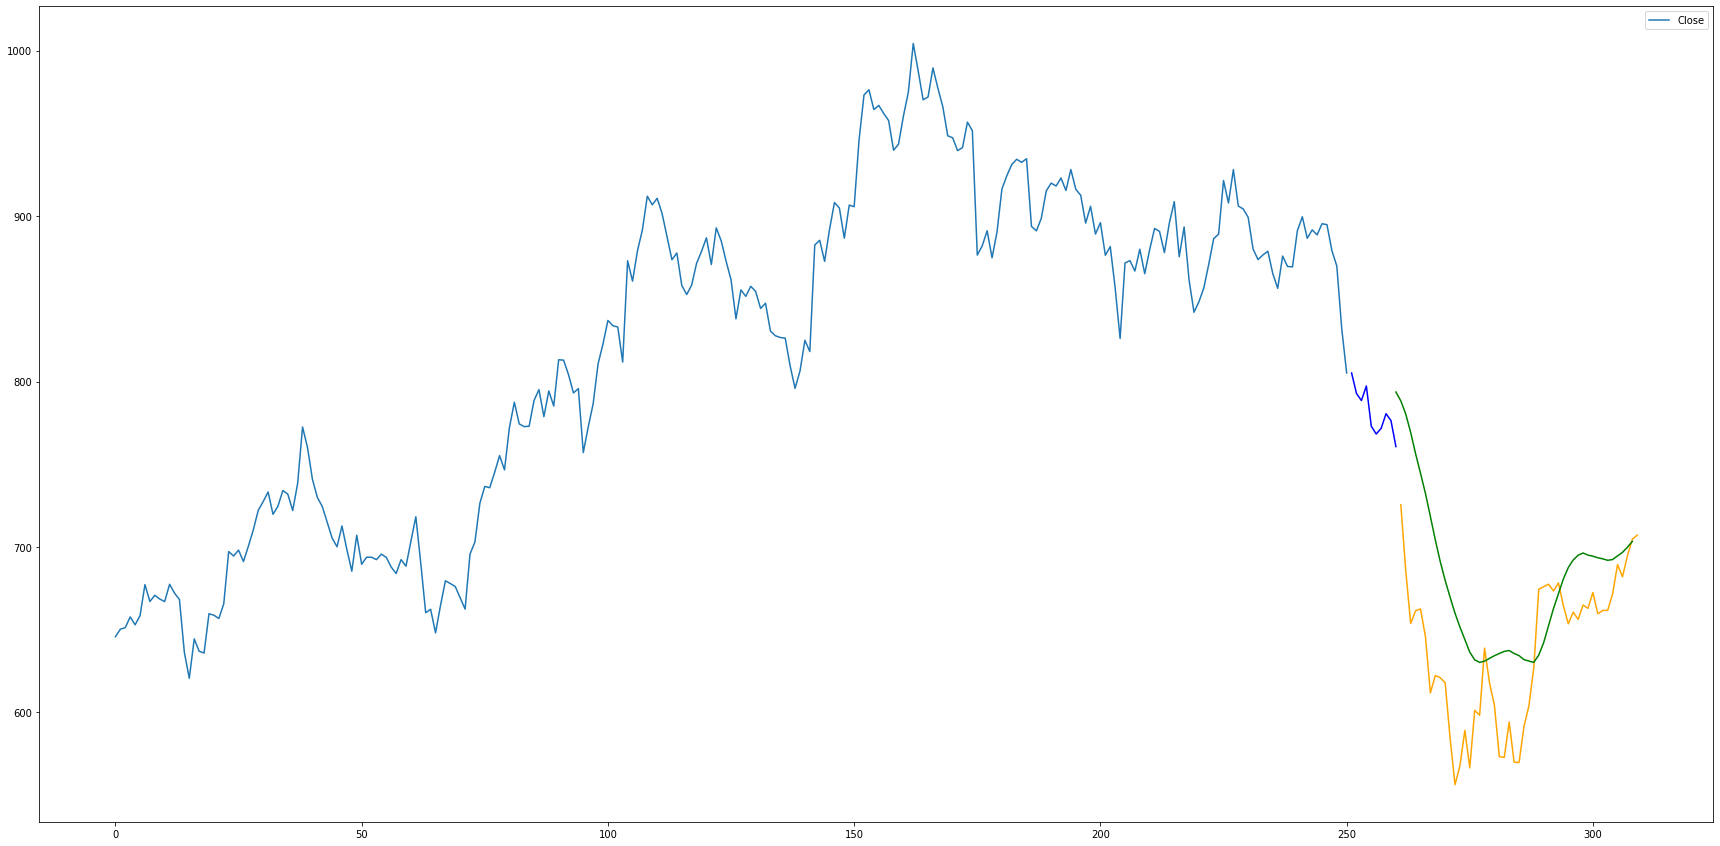

In [29]:
escorts_model_plt = escorts_train_plot_copy.plot(y=['Close'], figsize=(30,15))
escorts_model_plt.plot(escorts_test_plot_copy["Close"][:10], c='blue')
escorts_model_plt.plot(escorts_test_plot_copy["Close"][10:], c='orange')
escorts_model_plt.plot(closing_price, c='green')

__In the graph above:__
- We can see the training data in blue
- The test data in orange
- The predictions made by the models in green

# 4. Put the results in a file

In [30]:
escorts_predictions_df = pd.read_csv('Escorts_predicitions.csv')
escorts_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close,LSTM_Close
0,2018-08-06,880.049988,894.957322,814.415519,NaN
1,2018-08-07,873.700012,896.301668,807.619558,NaN
2,2018-08-08,876.500000,897.646014,816.193006,NaN
3,2018-08-09,878.750000,898.990361,799.530341,NaN
4,2018-08-10,865.250000,896.179214,790.553107,NaN


In [31]:
escorts_predictions_df.tail()

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close,LSTM_Close
54,2018-10-29,591.450012,914.288296,635.202474,675.80880
55,2018-10-30,603.950012,915.632642,637.882601,677.63070
56,2018-10-31,627.000000,916.976988,627.784426,679.40330
57,2018-11-01,674.450012,946.757216,620.437701,682.06274
58,2018-11-02,676.000000,917.122802,612.205215,685.04156


In [32]:
closing_price_df.index -= 250
closing_price_df

,price
10,793.652039
11,788.274902
12,780.333862
13,769.181641
14,756.301819
15,744.498169
16,732.342468
17,718.412231
18,704.270813
19,691.152893


In [33]:
escorts_predictions_df['LSTM_Close'] = closing_price_df['price']
escorts_predictions_df

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close,LSTM_Close
0,2018-08-06,880.049988,894.957322,814.415519,NaN
1,2018-08-07,873.700012,896.301668,807.619558,NaN
2,2018-08-08,876.500000,897.646014,816.193006,NaN
3,2018-08-09,878.750000,898.990361,799.530341,NaN
4,2018-08-10,865.250000,896.179214,790.553107,NaN
5,2018-08-13,856.299988,897.523561,789.476776,NaN
6,2018-08-14,875.799988,898.867907,795.684769,NaN
7,2018-08-16,869.500000,901.556599,800.431765,NaN
8,2018-08-17,869.299988,898.745453,794.861088,NaN
9,2018-08-20,891.200012,900.089799,789.315227,NaN


In [34]:
escorts_predictions_df.to_csv('Escorts_predicitions.csv', index=False)